In [1]:
import torch

t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)  # t_c are temperatures in Celsius
t_u = torch.tensor(t_u)  # t_u are our unknown units

In [2]:
def model(t_u, w, b):
    return w * t_u + b

In [3]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [4]:
w = torch.ones(1)
b = torch.zeros(1)

t_p = model(t_u, w, b)  # predicted temperatures
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])

In [5]:
loss = loss_fn(t_p, t_c)
loss

tensor(1763.8846)

In [6]:
delta = 0.1
loss_rate_of_change_w = \
    (loss_fn(model(t_u, w + delta, b), t_c) -
     loss_fn(model(t_u, w - delta, b), t_c)) / (2.0 * delta)
loss_rate_of_change_w

tensor(4517.2979)

In [7]:
learning_rate = 1e-2

w = w - learning_rate * loss_rate_of_change_w
w

tensor([-44.1730])

$
w := w - \alpha \cdot \frac{\partial \mathcal{L}}{\partial w} \\
\frac{\partial \mathcal{L}}{\partial w} \approx \frac{\mathcal{L}(w, b + \delta) - \mathcal{L}(w, b - \delta)}{2\delta} \approx \frac{\mathcal{L}(w, b + \delta) - \mathcal{L}(w, b)}{\delta} \\
\frac{\partial \mathcal{L}}{\partial w} = \lim\limits_{\delta\to0} \frac{\mathcal{L}(w, b + \delta) - \mathcal{L}(w, b)}{\delta}
$

In [8]:
loss_rate_of_change_b = \
    (loss_fn(model(t_u, w, b + delta), t_c) -
     loss_fn(model(t_u, w, b - delta), t_c)) / (2.0 * delta)

b = b - learning_rate * loss_rate_of_change_b
b

tensor([46.0250])

In [9]:
def dloss_fn(t_p, t_c):
    dsq_diffs = 2 * (t_p - t_c)
    return dsq_diffs

In [10]:
def dmodel_dw(t_u, w, b):
    return t_u

def dmodel_db(t_u, w, b):
    return 1.0

In [11]:
def grad_fn(t_u, t_c, t_p, w, b):
    dloss_dw = dloss_fn(t_p, t_c) * dmodel_dw(t_u, w, b)
    dloss_db = dloss_fn(t_p, t_c) * dmodel_db(t_u, w, b)
    return torch.stack([dloss_dw.mean(), dloss_db.mean()])

In [18]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c, print_params=True):
    for epoch in range(1, n_epochs + 1):
        w, b = params

        t_p = model(t_u, w, b)  # <1>
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)  # <2>

        params = params - learning_rate * grad

        if epoch in {1, 2, 3, 10, 11, 99, 100, 4000, 5000}:  # <3>
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            if print_params:
                print('    Params:', params)
                print('    Grad:  ', grad)
        if epoch in {4, 12, 101}:
            print('...')

        if not torch.isfinite(loss).all():
            break  # <3>
            
    return params

In [19]:
training_loop(
    n_epochs = 300,
    learning_rate = 2e-4,
    params = torch.tensor([1.0, 0.0]),
    t_u = t_u,
    t_c = t_c)

Epoch 1, Loss 1763.884644
    Params: tensor([ 0.0965, -0.0165])
    Grad:   tensor([4517.2964,   82.6000])
Epoch 2, Loss 83.266373
    Params: tensor([ 0.2562, -0.0143])
    Grad:   tensor([-798.1978,  -11.0314])
Epoch 3, Loss 30.800209
    Params: tensor([ 0.2280, -0.0154])
    Grad:   tensor([140.9661,   5.5117])
...
Epoch 10, Loss 29.096800
    Params: tensor([ 0.2323, -0.0196])
    Grad:   tensor([-0.0541,  3.0269])
Epoch 11, Loss 29.094965
    Params: tensor([ 0.2323, -0.0202])
    Grad:   tensor([-0.0531,  3.0268])
...
Epoch 99, Loss 28.934168
    Params: tensor([ 0.2332, -0.0734])
    Grad:   tensor([-0.0531,  3.0175])
Epoch 100, Loss 28.932344
    Params: tensor([ 0.2333, -0.0740])
    Grad:   tensor([-0.0531,  3.0174])
...


tensor([ 0.2354, -0.1942])

In [20]:
t_un = 0.1 * t_u
t_un

tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])

In [23]:
import time
tic = time.time()

params = training_loop(
    n_epochs = 5000,
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0]),
    t_u = t_un,
    t_c = t_c)

toc = time.time()
print('Spent time: ' + str(toc - tic) + 's')

Epoch 1, Loss 80.364342
    Params: tensor([1.7761, 0.1064])
    Grad:   tensor([-77.6140, -10.6400])
Epoch 2, Loss 37.574917
    Params: tensor([2.0848, 0.1303])
    Grad:   tensor([-30.8623,  -2.3864])
Epoch 3, Loss 30.871077
    Params: tensor([2.2094, 0.1217])
    Grad:   tensor([-12.4631,   0.8587])
...
Epoch 10, Loss 29.030487
    Params: tensor([ 2.3232, -0.0710])
    Grad:   tensor([-0.5355,  2.9295])
Epoch 11, Loss 28.941875
    Params: tensor([ 2.3284, -0.1003])
    Grad:   tensor([-0.5240,  2.9264])
...
Epoch 99, Loss 22.214186
    Params: tensor([ 2.7508, -2.4910])
    Grad:   tensor([-0.4453,  2.5208])
Epoch 100, Loss 22.148710
    Params: tensor([ 2.7553, -2.5162])
    Grad:   tensor([-0.4445,  2.5165])
...
Epoch 4000, Loss 2.927680
    Params: tensor([  5.3643, -17.2853])
    Grad:   tensor([-0.0006,  0.0033])
Epoch 5000, Loss 2.927648
    Params: tensor([  5.3671, -17.3012])
    Grad:   tensor([-0.0001,  0.0006])
Spent time: 1.6022617816925049s


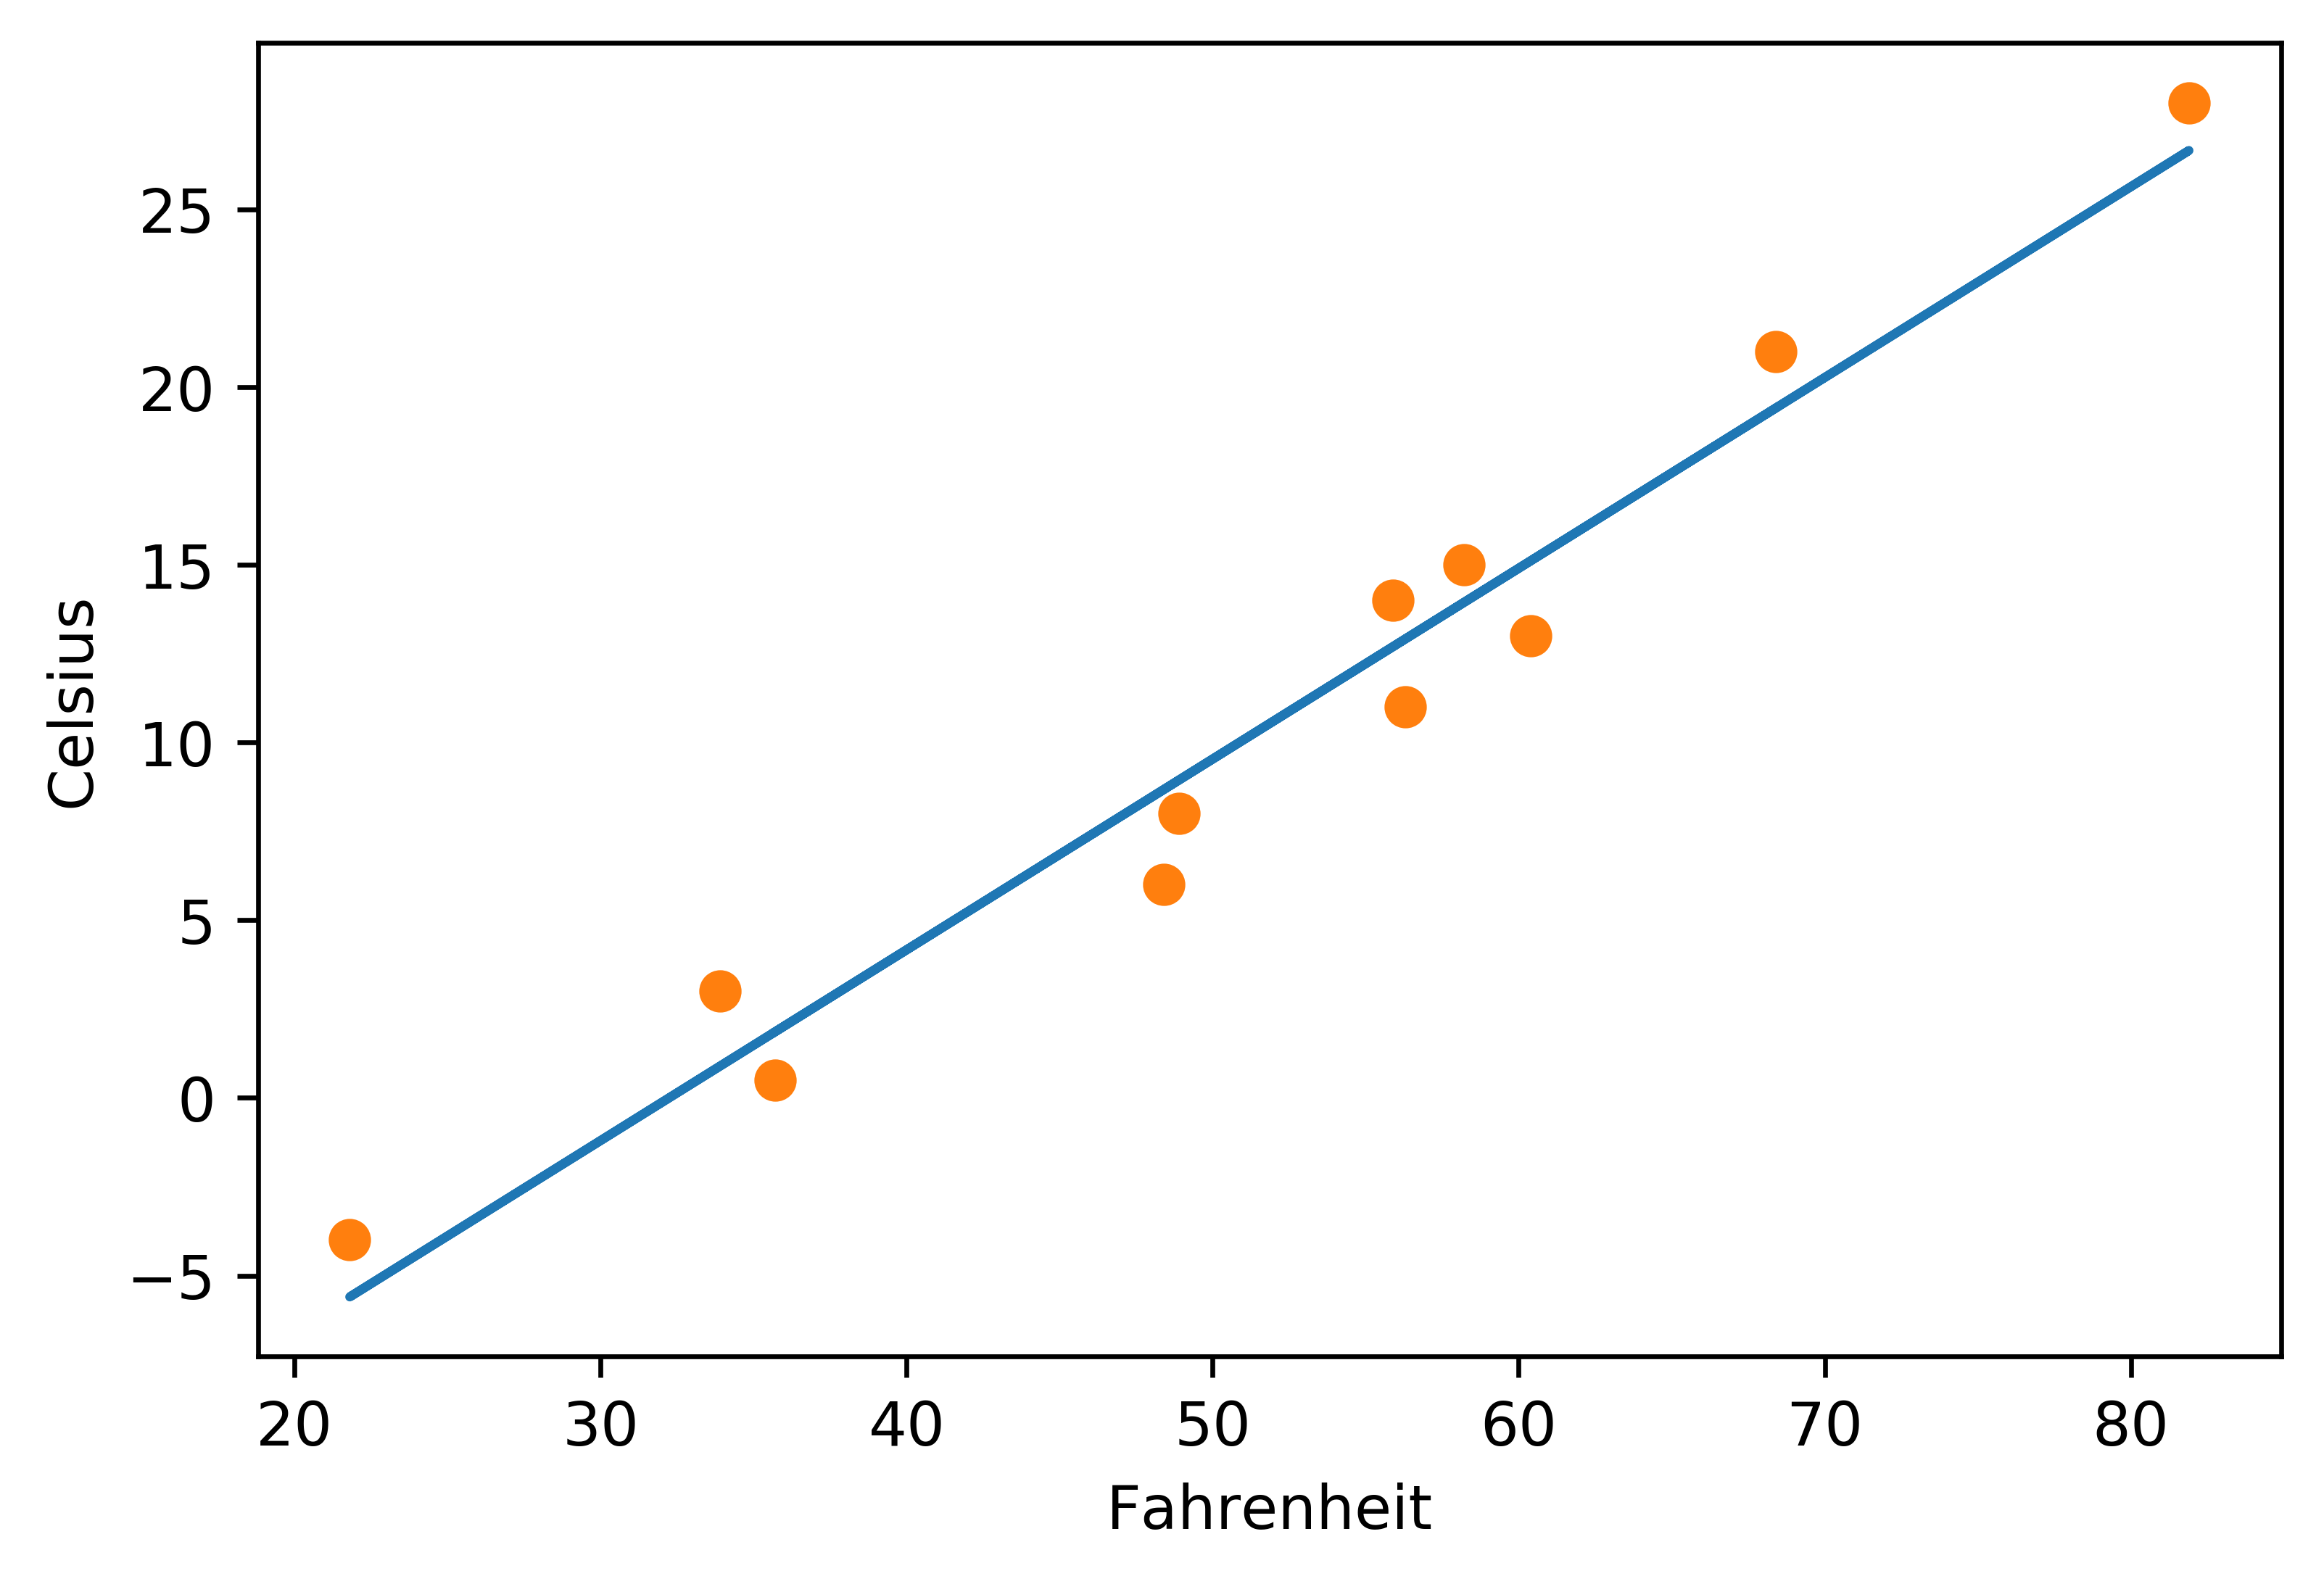

In [24]:
%matplotlib inline
from matplotlib import pyplot as plt

t_p = model(t_un, *params)

fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')